In [ ]:
!pip install lightly

In [ ]:
import torch
from torch import nn
import torchvision
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import re
import pandas as pd
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from datetime import datetime, date
from tqdm import tqdm

from lightly.data import LightlyDataset
from lightly.data.collate import VICRegCollateFunction
from lightly.models.modules import BarlowTwinsProjectionHead
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from lightly.loss import VICRegLoss
from lightly.loss import TiCoLoss
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from torch.utils.data import SubsetRandomSampler
import warnings
warnings.filterwarnings("ignore")

Загрузим и обучим модель 

In [ ]:

class VICReg(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        # не использовать при обучении
        self.projection_head = BarlowTwinsProjectionHead(512, 2048, 2048)

    def forward(self, x):
        x = self.backbone(x).flatten(start_dim=1)
        if self.training:
          out = self.projection_head(x)
        else:
          out = x
        return out


resnet = torchvision.models.resnet18()
backbone = nn.Sequential(*list(resnet.children())[:-1])
model = VICReg(backbone)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

cifar10 = torchvision.datasets.CIFAR10("datasets/cifar10", train=True, download=True)
dataset = LightlyDataset.from_torch_dataset(cifar10)
# or create a dataset from a folder containing images or videos:
# dataset = LightlyDataset("path/to/folder")

collate_fn = VICRegCollateFunction(input_size=32)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=256,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=8,
)

criterion = VICRegLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.06)

print("Starting Training")
model.train()
for epoch in range(20):
    total_loss = 0
    for (x0, x1), _, _ in dataloader:
        x0 = x0.to(device)
        x1 = x1.to(device)
        z0 = model(x0)
        z1 = model(x1)
        loss = criterion(z0, z1)
        total_loss += loss.detach()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    avg_loss = total_loss / len(dataloader)
    print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")

100%|██████████| 170498071/170498071 [00:13<00:00, 12819621.05it/s]


Extracting datasets/cifar10/cifar-10-python.tar.gz to datasets/cifar10
Starting Training
epoch: 00, loss: 21.52512
epoch: 01, loss: 21.24959
epoch: 02, loss: 21.12233
epoch: 03, loss: 21.00335
epoch: 04, loss: 20.94269
epoch: 05, loss: 20.87648
epoch: 06, loss: 20.82582
epoch: 07, loss: 20.76530
epoch: 08, loss: 20.73614
epoch: 09, loss: 20.69695
epoch: 10, loss: 20.64691
epoch: 11, loss: 20.62941
epoch: 12, loss: 20.59234
epoch: 13, loss: 20.56059
epoch: 14, loss: 20.53730
epoch: 15, loss: 20.51612
epoch: 16, loss: 20.48795
epoch: 17, loss: 20.46026
epoch: 18, loss: 20.44532
epoch: 19, loss: 20.43052


Проверим на линейной регрессии

In [ ]:
model.eval()
clf = LogisticRegression(random_state=0)
for (x0, x1), _1, _2 in dataloader:
  clf.fit(model(x0.to(device)).cpu().detach().numpy(), _1)

Посчитаем f1_score и Accuracy на тесте

In [ ]:
cifar10_test = torchvision.datasets.CIFAR10("datasets/cifar10", train=False, download=True)
testset = LightlyDataset.from_torch_dataset(cifar10_test)
# or create a dataset from a folder containing images or videos:
# dataset = LightlyDataset("path/to/folder")

collate_fn = VICRegCollateFunction(input_size=32)

test = torch.utils.data.DataLoader(
    testset,
    batch_size=256,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=8,
)

acur = []
for (x0, x1), _1, _2 in test:
  acur.append(accuracy_score(_1, clf.predict(model(x0.to(device)).cpu().detach().numpy())))

Files already downloaded and verified


In [ ]:
print(np.mean(acur))

0.2900641025641026


Возьмем более мощную 

In [ ]:
class VICReg(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        self.projection_head = BarlowTwinsProjectionHead(2048, 2048, 2048)

    def forward(self, x):
        x = self.backbone(x).flatten(start_dim=1)
        if self.training:
          out = self.projection_head(x)
        else:
          out = x
        return out


resnet = torch.hub.load('facebookresearch/vicreg:main', 'resnet50')
backbone = nn.Sequential(*list(resnet.children())[:-1])
model_pre = VICReg(backbone)

device = "cuda" if torch.cuda.is_available() else "cpu"
model_pre.to(device)

cifar10 = torchvision.datasets.CIFAR10("datasets/cifar10", train=True, download=True)
dataset = LightlyDataset.from_torch_dataset(cifar10)
# or create a dataset from a folder containing images or videos:
# dataset = LightlyDataset("path/to/folder")

collate_fn = VICRegCollateFunction(input_size=32)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=256,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=8,
)

criterion = VICRegLoss()
optimizer = torch.optim.SGD(model_pre.parameters(), lr=0.06)

print("Starting Training")
model_pre.train()
for epoch in range(10):
    total_loss = 0
    for (x0, x1), _, _ in dataloader:
        x0 = x0.to(device)
        x1 = x1.to(device)
        z0 = model_pre(x0)
        z1 = model_pre(x1)
        loss = criterion(z0, z1)
        total_loss += loss.detach()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    avg_loss = total_loss / len(dataloader)
    print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")

Downloading: "https://github.com/facebookresearch/vicreg/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/vicreg/resnet50.pth" to /root/.cache/torch/hub/checkpoints/resnet50.pth


  0%|          | 0.00/90.0M [00:00<?, ?B/s]

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting datasets/cifar10/cifar-10-python.tar.gz to datasets/cifar10
Starting Training


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


epoch: 00, loss: 21.64019
epoch: 01, loss: 21.33384
epoch: 02, loss: 21.14777
epoch: 03, loss: 20.99643
epoch: 04, loss: 20.87483
epoch: 05, loss: 20.76828
epoch: 06, loss: 20.69215
epoch: 07, loss: 20.61201
epoch: 08, loss: 20.54822
epoch: 09, loss: 20.47334


In [ ]:
model_pre.eval()
clf = LogisticRegression(random_state=0)
for (x0, x1), _1, _2 in dataloader:
  clf.fit(model_pre(x0.to(device)).cpu().detach().numpy(), _1)
  break

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
cifar10_test = torchvision.datasets.CIFAR10("datasets/cifar10", train=False, download=True)
testset = LightlyDataset.from_torch_dataset(cifar10_test)
# or create a dataset from a folder containing images or videos:
# dataset = LightlyDataset("path/to/folder")

collate_fn = VICRegCollateFunction(input_size=32)

test = torch.utils.data.DataLoader(
    testset,
    batch_size=256,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=8,
)

for (x0, x1), _1, _2 in test:
  print(model_pre(x0.to(device)).shape)
  print("f1_score: ", f1_score(_1, clf.predict(model_pre(x0.to(device)).cpu().detach().numpy()), average='macro'))
  print("Accuracy: ", accuracy_score(_1, clf.predict(model_pre(x0.to(device)).cpu().detach().numpy())))
  break

Files already downloaded and verified


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([256, 2048])
f1_score:  0.3031101612031156
Accuracy:  0.32421875


Протестируем поведение модели при изменении некоторых параметров

In [ ]:
class VICReg(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        self.projection_head = BarlowTwinsProjectionHead(2048, 2048, 2048)

    def forward(self, x):
        x = self.backbone(x).flatten(start_dim=1)
        if self.training:
          out = self.projection_head(x)
        else:
          out = x
        return out


def modeler(a={'lambda':[20,25,30], 'mu': [20,25,30], 'nu': [0.9, 1, 1.1]}):
    res = []
    losses_plots = []
    for lamb in a['lambda']:
        for mu in a['mu']:
            for nu in a['nu']:
                loes = []
                print("Experiment with \n lambda: ", lamb, '\n', 'mu_param: ', mu,  '\n', 'nu_param: ', nu, '\n')
                resnet = torch.hub.load('facebookresearch/vicreg:main', 'resnet50')
                backbone = nn.Sequential(*list(resnet.children())[:-1])
                model_pre = VICReg(backbone)

                device = "cuda" if torch.cuda.is_available() else "cpu"
                model_pre.to(device)

                cifar10 = torchvision.datasets.CIFAR10("datasets/cifar10", train=True, download=True)
                dataset = LightlyDataset.from_torch_dataset(cifar10)
                # or create a dataset from a folder containing images or videos:
                # dataset = LightlyDataset("path/to/folder")

                collate_fn = VICRegCollateFunction(input_size=32)


                dataloader = torch.utils.data.DataLoader(
                    dataset,
                    batch_size=256,
                    collate_fn=collate_fn,
                    shuffle=True,
                    drop_last=True,
                    num_workers=4,
                )

                criterion = VICRegLoss(lambda_param=lamb, mu_param=mu, nu_param=nu)
                optimizer = torch.optim.SGD(model_pre.parameters(), lr=0.06)

                print("Starting Training")
                model_pre.train()
                for epoch in range(10):
                    total_loss = 0
                    for (x0, x1), _, _ in dataloader:
                        x0 = x0.to(device)
                        x1 = x1.to(device)
                        z0 = model_pre(x0)
                        z1 = model_pre(x1)
                        loss = criterion(z0, z1)
                        total_loss += loss.detach()
                        loss.backward()
                        optimizer.step()
                        optimizer.zero_grad()
                    avg_loss = total_loss / len(dataloader)
                    loes.append(avg_loss)
                    print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")
                
                losses_plots.append(loes)

                model_pre.eval()
                clf = LogisticRegression(random_state=0)
                for (x0, x1), _1, _2 in dataloader:
                    clf.fit(model_pre(x0.to(device)).cpu().detach().numpy(), _1)
                    break

        
                cifar10_test = torchvision.datasets.CIFAR10("datasets/cifar10", train=False, download=True)
                testset = LightlyDataset.from_torch_dataset(cifar10_test)
                # or create a dataset from a folder containing images or videos:
                # dataset = LightlyDataset("path/to/folder")

                collate_fn = VICRegCollateFunction(input_size=32)

                test = torch.utils.data.DataLoader(
                    testset,
                    batch_size=256,
                        collate_fn=collate_fn,
                    shuffle=True,
                    drop_last=True,
                    num_workers=4,
                )
                for (x0, x1), _1, _2 in test:
                    print(model_pre(x0.to(device)).shape)
                    print("f1_score: ", f1_score(_1, clf.predict(model_pre(x0.to(device)).cpu().detach().numpy()), average='macro'))
                    print("Accuracy: ", accuracy_score(_1, clf.predict(model_pre(x0.to(device)).cpu().detach().numpy())))
                    break
                res.append((lamb, mu, nu, accuracy_score(_1, clf.predict(model_pre(x0.to(device)).cpu().detach().numpy()))))
    return res, losses_plots

In [ ]:
result, plo = modeler({'lambda':[20,25,30], 'mu': [25], 'nu': [1]})

Experiment with 
 lambda:  20 
 mu_param:  25 
 nu_param:  1 



Downloading: "https://github.com/facebookresearch/vicreg/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/vicreg/resnet50.pth" to /root/.cache/torch/hub/checkpoints/resnet50.pth


  0%|          | 0.00/90.0M [00:00<?, ?B/s]

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting datasets/cifar10/cifar-10-python.tar.gz to datasets/cifar10
Starting Training


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


epoch: 00, loss: 20.90761
epoch: 01, loss: 20.67711
epoch: 02, loss: 20.52335
epoch: 03, loss: 20.39984
epoch: 04, loss: 20.28861
epoch: 05, loss: 20.18022
epoch: 06, loss: 20.09430
epoch: 07, loss: 20.02786
epoch: 08, loss: 19.97095
epoch: 09, loss: 19.89023


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Files already downloaded and verified


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([256, 2048])
f1_score:  0.26660101044547346
Accuracy:  0.26953125
Experiment with 
 lambda:  25 
 mu_param:  25 
 nu_param:  1 



Using cache found in /root/.cache/torch/hub/facebookresearch_vicreg_main


Files already downloaded and verified
Starting Training


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


epoch: 00, loss: 21.64521
epoch: 01, loss: 21.33784
epoch: 02, loss: 21.15344
epoch: 03, loss: 21.00083
epoch: 04, loss: 20.88346
epoch: 05, loss: 20.77632
epoch: 06, loss: 20.70036
epoch: 07, loss: 20.61836
epoch: 08, loss: 20.54167
epoch: 09, loss: 20.48841


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Files already downloaded and verified


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([256, 2048])
f1_score:  0.3594784811839936
Accuracy:  0.359375
Experiment with 
 lambda:  30 
 mu_param:  25 
 nu_param:  1 



Using cache found in /root/.cache/torch/hub/facebookresearch_vicreg_main


Files already downloaded and verified
Starting Training


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


epoch: 00, loss: 22.17760
epoch: 01, loss: 21.77326
epoch: 02, loss: 21.57330
epoch: 03, loss: 21.41125
epoch: 04, loss: 21.29565
epoch: 05, loss: 21.19641
epoch: 06, loss: 21.10430
epoch: 07, loss: 21.02945
epoch: 08, loss: 20.97736
epoch: 09, loss: 20.91443


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Files already downloaded and verified


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([256, 2048])
f1_score:  0.30764106136999575
Accuracy:  0.31640625


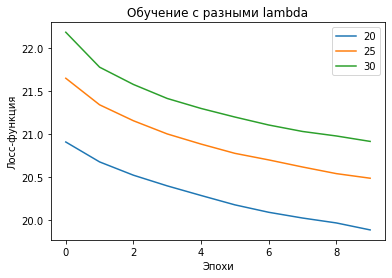

In [ ]:
nubers = []
for t in range(len(plo)):
    r = []
    for i in range(len(plo[t])):
        r.append(plo[t][i].cpu().detach().numpy())
    nubers.append(r)
data = np.array(nubers)


plt.plot(data[0], label="20")
plt.plot(data[1], label="25")
plt.plot(data[2], label="30")
plt.title("Обучение с разными lambda")
plt.ylabel("Лосс-функция")
plt.xlabel("Эпохи")
plt.legend()

In [ ]:
acuur = []
for ac in result:
    acuur.append(ac[3])
print('Lambda: ', result[np.argmax(acuur)][0], '; mu param: ', result[np.argmax(acuur)][1],
      '; nu param: ', result[np.argmax(acuur)][2], '\nBest Accuracy: ', result[np.argmax(acuur)][3])

Lambda:  25 ; mu param:  25 ; nu param:  1 
Best Accuracy:  0.359375


In [ ]:
result, plo = modeler({'lambda':[25], 'mu': [20,25,30], 'nu': [1]})

Experiment with 
 lambda:  25 
 mu_param:  20 
 nu_param:  1 



Downloading: "https://github.com/facebookresearch/vicreg/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/vicreg/resnet50.pth" to /root/.cache/torch/hub/checkpoints/resnet50.pth


  0%|          | 0.00/90.0M [00:00<?, ?B/s]

Files already downloaded and verified
Starting Training


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


epoch: 00, loss: 17.92243
epoch: 01, loss: 17.62546
epoch: 02, loss: 17.48533
epoch: 03, loss: 17.38373
epoch: 04, loss: 17.30057
epoch: 05, loss: 17.22609
epoch: 06, loss: 17.16477
epoch: 07, loss: 17.11214
epoch: 08, loss: 17.06466
epoch: 09, loss: 17.02824


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Files already downloaded and verified


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([256, 2048])
f1_score:  0.284785185510359
Accuracy:  0.3046875
Experiment with 
 lambda:  25 
 mu_param:  25 
 nu_param:  1 



Using cache found in /root/.cache/torch/hub/facebookresearch_vicreg_main


Files already downloaded and verified
Starting Training


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


epoch: 00, loss: 21.64356
epoch: 01, loss: 21.32762
epoch: 02, loss: 21.14358
epoch: 03, loss: 20.98853
epoch: 04, loss: 20.86847
epoch: 05, loss: 20.76931
epoch: 06, loss: 20.68378
epoch: 07, loss: 20.60818
epoch: 08, loss: 20.53948
epoch: 09, loss: 20.47333
Files already downloaded and verified


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([256, 2048])
f1_score:  0.35065622109465205
Accuracy:  0.359375
Experiment with 
 lambda:  25 
 mu_param:  30 
 nu_param:  1 



Using cache found in /root/.cache/torch/hub/facebookresearch_vicreg_main


Files already downloaded and verified
Starting Training


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


epoch: 00, loss: 25.14371
epoch: 01, loss: 24.77971
epoch: 02, loss: 24.54649
epoch: 03, loss: 24.35077
epoch: 04, loss: 24.18273
epoch: 05, loss: 24.04783
epoch: 06, loss: 23.93672
epoch: 07, loss: 23.84186
epoch: 08, loss: 23.74419
epoch: 09, loss: 23.67134


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Files already downloaded and verified


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([256, 2048])
f1_score:  0.30653202611113806
Accuracy:  0.31640625


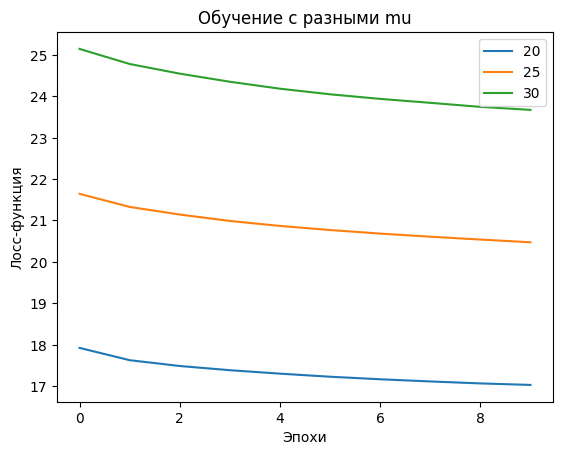

In [ ]:
nubers = []
for t in range(len(plo)):
    r = []
    for i in range(len(plo[t])):
        r.append(plo[t][i].cpu().detach().numpy())
    nubers.append(r)
data = np.array(nubers)


plt.plot(data[0], label="20")
plt.plot(data[1], label="25")
plt.plot(data[2], label="30")
plt.title("Обучение с разными mu")
plt.ylabel("Лосс-функция")
plt.xlabel("Эпохи")
plt.legend()

In [ ]:
acuur = []
for ac in result:
    acuur.append(ac[3])
print('Lambda: ', result[np.argmax(acuur)][0], '; mu param: ', result[np.argmax(acuur)][1],
      '; nu param: ', result[np.argmax(acuur)][2], '\nBest Accuracy: ', result[np.argmax(acuur)][3])

Lambda:  25 ; mu param:  25 ; nu param:  1 
Best Accuracy:  0.359375


In [ ]:
result, plo = modeler({'lambda':[25], 'mu': [25], 'nu': [0.9, 1, 1.1]})

Experiment with 
 lambda:  25 
 mu_param:  25 
 nu_param:  0.9 



Downloading: "https://github.com/facebookresearch/vicreg/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/vicreg/resnet50.pth" to /root/.cache/torch/hub/checkpoints/resnet50.pth


  0%|          | 0.00/90.0M [00:00<?, ?B/s]

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting datasets/cifar10/cifar-10-python.tar.gz to datasets/cifar10
Starting Training


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


epoch: 00, loss: 21.62104
epoch: 01, loss: 21.28897
epoch: 02, loss: 21.08515
epoch: 03, loss: 20.92365
epoch: 04, loss: 20.79423
epoch: 05, loss: 20.69515
epoch: 06, loss: 20.60071
epoch: 07, loss: 20.52314
epoch: 08, loss: 20.45605
epoch: 09, loss: 20.38934


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Files already downloaded and verified


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([256, 2048])
f1_score:  0.337328822990652
Accuracy:  0.3359375
Experiment with 
 lambda:  25 
 mu_param:  25 
 nu_param:  1 



Using cache found in /root/.cache/torch/hub/facebookresearch_vicreg_main


Files already downloaded and verified
Starting Training


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


epoch: 00, loss: 21.64739
epoch: 01, loss: 21.32811
epoch: 02, loss: 21.13821
epoch: 03, loss: 20.99790
epoch: 04, loss: 20.87849
epoch: 05, loss: 20.77113
epoch: 06, loss: 20.68899
epoch: 07, loss: 20.61167
epoch: 08, loss: 20.53091
epoch: 09, loss: 20.47932


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Files already downloaded and verified


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([256, 2048])
f1_score:  0.26639451791068375
Accuracy:  0.28125
Experiment with 
 lambda:  25 
 mu_param:  25 
 nu_param:  1.1 



Using cache found in /root/.cache/torch/hub/facebookresearch_vicreg_main


Files already downloaded and verified
Starting Training


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


epoch: 00, loss: 21.66588
epoch: 01, loss: 21.37381
epoch: 02, loss: 21.20933
epoch: 03, loss: 21.06110
epoch: 04, loss: 20.94727
epoch: 05, loss: 20.84591
epoch: 06, loss: 20.76822
epoch: 07, loss: 20.69430
epoch: 08, loss: 20.62982
epoch: 09, loss: 20.57049


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Files already downloaded and verified


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([256, 2048])
f1_score:  0.31772550385051207
Accuracy:  0.32421875


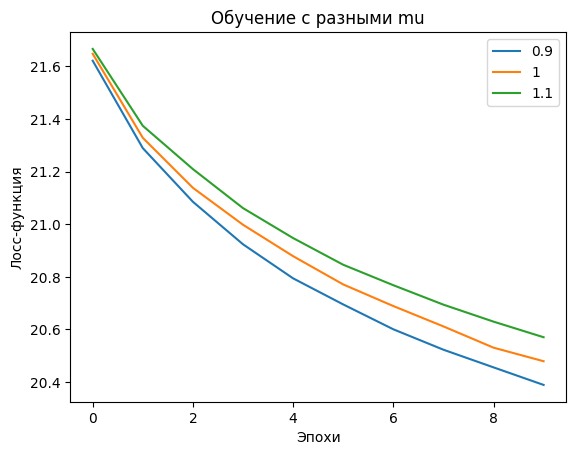

In [ ]:
nubers = []
for t in range(len(plo)):
    r = []
    for i in range(len(plo[t])):
        r.append(plo[t][i].cpu().detach().numpy())
    nubers.append(r)
data = np.array(nubers)


plt.plot(data[0], label="0.9")
plt.plot(data[1], label="1")
plt.plot(data[2], label="1.1")
plt.title("Обучение с разными nu")
plt.ylabel("Лосс-функция")
plt.xlabel("Эпохи")
plt.legend()

In [ ]:
acuur = []
for ac in result:
    acuur.append(ac[3])
print('Lambda: ', result[np.argmax(acuur)][0], '; mu param: ', result[np.argmax(acuur)][1],
      '; nu param: ', result[np.argmax(acuur)][2], '\nBest Accuracy: ', result[np.argmax(acuur)][3])

Lambda:  25 ; mu param:  25 ; nu param:  0.9 
Best Accuracy:  0.3359375


Проверим влияние размера батча

In [ ]:
class VICReg(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        self.projection_head = BarlowTwinsProjectionHead(2048, 2048, 2048)

    def forward(self, x):
        x = self.backbone(x).flatten(start_dim=1)
        if self.training:
          out = self.projection_head(x)
        else:
          out = x
        return out


resnet = torch.hub.load('facebookresearch/vicreg:main', 'resnet50')
backbone = nn.Sequential(*list(resnet.children())[:-1])
model_pre = VICReg(backbone)

device = "cuda" if torch.cuda.is_available() else "cpu"
model_pre.to(device)

cifar10 = torchvision.datasets.CIFAR10("datasets/cifar10", train=True, download=True)
dataset = LightlyDataset.from_torch_dataset(cifar10)
# or create a dataset from a folder containing images or videos:
# dataset = LightlyDataset("path/to/folder")

collate_fn = VICRegCollateFunction(input_size=32)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=512,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=8,
)

criterion = VICRegLoss()
optimizer = torch.optim.SGD(model_pre.parameters(), lr=0.06)

print("Starting Training")
model_pre.train()
for epoch in tqdm(range(10)):
    total_loss = 0
    for (x0, x1), _, _ in dataloader:
        x0 = x0.to(device)
        x1 = x1.to(device)
        z0 = model_pre(x0)
        z1 = model_pre(x1)
        loss = criterion(z0, z1)
        total_loss += loss.detach()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    avg_loss = total_loss / len(dataloader)
    print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")

Using cache found in /root/.cache/torch/hub/facebookresearch_vicreg_main


Files already downloaded and verified


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Starting Training


 10%|█         | 1/10 [01:39<14:59, 99.97s/it]

epoch: 00, loss: 21.73225


 20%|██        | 2/10 [03:17<13:08, 98.62s/it]

epoch: 01, loss: 21.44596


 30%|███       | 3/10 [04:55<11:27, 98.16s/it]

epoch: 02, loss: 21.28957


 40%|████      | 4/10 [06:31<09:43, 97.30s/it]

epoch: 03, loss: 21.18126


 50%|█████     | 5/10 [08:06<08:02, 96.41s/it]

epoch: 04, loss: 21.07458


 60%|██████    | 6/10 [09:42<06:25, 96.37s/it]

epoch: 05, loss: 20.99044


 70%|███████   | 7/10 [11:17<04:48, 96.02s/it]

epoch: 06, loss: 20.90673


 80%|████████  | 8/10 [12:54<03:12, 96.25s/it]

epoch: 07, loss: 20.83806


 90%|█████████ | 9/10 [14:30<01:36, 96.12s/it]

epoch: 08, loss: 20.77917


100%|██████████| 10/10 [16:09<00:00, 96.96s/it]

epoch: 09, loss: 20.71335


In [ ]:
model_pre.eval()
clf = LogisticRegression(random_state=0)
for (x0, x1), _1, _2 in dataloader:
  clf.fit(model_pre(x0.to(device)).cpu().detach().numpy(), _1)
  break

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
cifar10_test = torchvision.datasets.CIFAR10("datasets/cifar10", train=False, download=True)
testset = LightlyDataset.from_torch_dataset(cifar10_test)
# or create a dataset from a folder containing images or videos:
# dataset = LightlyDataset("path/to/folder")

collate_fn = VICRegCollateFunction(input_size=32)

test = torch.utils.data.DataLoader(
    testset,
    batch_size=256,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=8,
)

for (x0, x1), _1, _2 in test:
  print(model_pre(x0.to(device)).shape)
  print("f1_score: ", f1_score(_1, clf.predict(model_pre(x0.to(device)).cpu().detach().numpy()), average='macro'))
  print("Accuracy: ", accuracy_score(_1, clf.predict(model_pre(x0.to(device)).cpu().detach().numpy())))
  break

Files already downloaded and verified


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([256, 2048])
f1_score:  0.31055165687620406
Accuracy:  0.30859375


In [ ]:
class VICReg(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        self.projection_head = BarlowTwinsProjectionHead(2048, 2048, 2048)

    def forward(self, x):
        x = self.backbone(x).flatten(start_dim=1)
        if self.training:
          out = self.projection_head(x)
        else:
          out = x
        return out


resnet = torch.hub.load('facebookresearch/vicreg:main', 'resnet50')
backbone = nn.Sequential(*list(resnet.children())[:-1])
model_pre = VICReg(backbone)

device = "cuda" if torch.cuda.is_available() else "cpu"
model_pre.to(device)

cifar10 = torchvision.datasets.CIFAR10("datasets/cifar10", train=True, download=True)
dataset = LightlyDataset.from_torch_dataset(cifar10)
# or create a dataset from a folder containing images or videos:
# dataset = LightlyDataset("path/to/folder")

collate_fn = VICRegCollateFunction(input_size=32)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=1024,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=2,
)

criterion = VICRegLoss()
optimizer = torch.optim.SGD(model_pre.parameters(), lr=0.06)

print("Starting Training")
model_pre.train()
for epoch in tqdm(range(10)):
    total_loss = 0
    for (x0, x1), _, _ in dataloader:
        x0 = x0.to(device)
        x1 = x1.to(device)
        z0 = model_pre(x0)
        z1 = model_pre(x1)
        loss = criterion(z0, z1)
        total_loss += loss.detach()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    avg_loss = total_loss / len(dataloader)
    print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")

Using cache found in /root/.cache/torch/hub/facebookresearch_vicreg_main


Files already downloaded and verified
Starting Training


 10%|█         | 1/10 [01:38<14:45, 98.41s/it]

epoch: 00, loss: 21.80748


 20%|██        | 2/10 [03:18<13:13, 99.17s/it]

epoch: 01, loss: 21.58313


 30%|███       | 3/10 [04:57<11:35, 99.32s/it]

epoch: 02, loss: 21.46108


 40%|████      | 4/10 [06:36<09:54, 99.17s/it]

epoch: 03, loss: 21.36936


 50%|█████     | 5/10 [08:15<08:15, 99.18s/it]

epoch: 04, loss: 21.29411


 60%|██████    | 6/10 [09:54<06:36, 99.10s/it]

epoch: 05, loss: 21.23114


 70%|███████   | 7/10 [11:32<04:56, 98.75s/it]

epoch: 06, loss: 21.16974


 80%|████████  | 8/10 [13:12<03:18, 99.03s/it]

epoch: 07, loss: 21.11376


 90%|█████████ | 9/10 [14:52<01:39, 99.26s/it]

epoch: 08, loss: 21.05457


100%|██████████| 10/10 [16:31<00:00, 99.14s/it]

epoch: 09, loss: 21.00115


In [ ]:
model_pre.eval()
clf = LogisticRegression(random_state=0)
for (x0, x1), _1, _2 in dataloader:
  clf.fit(model_pre(x0.to(device)).cpu().detach().numpy(), _1)
  break

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
cifar10_test = torchvision.datasets.CIFAR10("datasets/cifar10", train=False, download=True)
testset = LightlyDataset.from_torch_dataset(cifar10_test)
# or create a dataset from a folder containing images or videos:
# dataset = LightlyDataset("path/to/folder")

collate_fn = VICRegCollateFunction(input_size=32)

test = torch.utils.data.DataLoader(
    testset,
    batch_size=1024,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=2,
)

for (x0, x1), _1, _2 in test:
  print(model_pre(x0.to(device)).shape)
  print("f1_score: ", f1_score(_1, clf.predict(model_pre(x0.to(device)).cpu().detach().numpy()), average='macro'))
  print("Accuracy: ", accuracy_score(_1, clf.predict(model_pre(x0.to(device)).cpu().detach().numpy())))
  break

Files already downloaded and verified
torch.Size([1024, 2048])
f1_score:  0.28171381102896653
Accuracy:  0.2822265625


In [ ]:
class VICReg(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        self.projection_head = BarlowTwinsProjectionHead(2048, 2048, 2048)

    def forward(self, x):
        x = self.backbone(x).flatten(start_dim=1)
        if self.training:
          out = self.projection_head(x)
        else:
          out = x
        return out


resnet = torch.hub.load('facebookresearch/vicreg:main', 'resnet50')
backbone = nn.Sequential(*list(resnet.children())[:-1])
model_long = VICReg(backbone)

device = "cuda" if torch.cuda.is_available() else "cpu"
model_long.to(device)

cifar10 = torchvision.datasets.CIFAR10("datasets/cifar10", train=True, download=True)
dataset = LightlyDataset.from_torch_dataset(cifar10)
# or create a dataset from a folder containing images or videos:
# dataset = LightlyDataset("path/to/folder")

collate_fn = VICRegCollateFunction(input_size=32)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=256,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=2,
)

criterion = VICRegLoss()
optimizer = torch.optim.SGD(model_long.parameters(), lr=0.06)

train_loss_history = []
print("Starting Training")
model_long.train()
for epoch in tqdm(range(40)):
    total_loss = 0
    for (x0, x1), _, _ in dataloader:
        x0 = x0.to(device)
        x1 = x1.to(device)
        z0 = model_long(x0)
        z1 = model_long(x1)
        loss = criterion(z0, z1)
        total_loss += loss.detach()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    avg_loss = total_loss / len(dataloader)
    train_loss_history.append(avg_loss)
    print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")

Using cache found in /root/.cache/torch/hub/facebookresearch_vicreg_main


100%|██████████| 170498071/170498071 [00:02<00:00, 72905435.51it/s]


Extracting datasets/cifar10/cifar-10-python.tar.gz to datasets/cifar10
Starting Training


  2%|▎         | 1/40 [01:47<1:10:05, 107.84s/it]

epoch: 00, loss: 21.64156


  5%|▌         | 2/40 [03:28<1:05:39, 103.67s/it]

epoch: 01, loss: 21.34122


  8%|▊         | 3/40 [05:09<1:03:12, 102.51s/it]

epoch: 02, loss: 21.15540


 10%|█         | 4/40 [06:54<1:02:06, 103.52s/it]

epoch: 03, loss: 21.00587


 12%|█▎        | 5/40 [08:37<1:00:14, 103.28s/it]

epoch: 04, loss: 20.88482


 15%|█▌        | 6/40 [10:20<58:25, 103.10s/it]  

epoch: 05, loss: 20.78730


 18%|█▊        | 7/40 [12:04<56:52, 103.40s/it]

epoch: 06, loss: 20.67681


 20%|██        | 8/40 [13:46<54:56, 103.03s/it]

epoch: 07, loss: 20.61343


 22%|██▎       | 9/40 [15:30<53:21, 103.28s/it]

epoch: 08, loss: 20.56401


 25%|██▌       | 10/40 [17:14<51:40, 103.36s/it]

epoch: 09, loss: 20.48906


 28%|██▊       | 11/40 [18:58<50:06, 103.67s/it]

epoch: 10, loss: 20.43365


 30%|███       | 12/40 [20:42<48:30, 103.95s/it]

epoch: 11, loss: 20.37286


 32%|███▎      | 13/40 [22:26<46:39, 103.69s/it]

epoch: 12, loss: 20.32026


 35%|███▌      | 14/40 [24:07<44:40, 103.11s/it]

epoch: 13, loss: 20.30525


 38%|███▊      | 15/40 [25:53<43:13, 103.76s/it]

epoch: 14, loss: 20.25029


 40%|████      | 16/40 [27:37<41:33, 103.89s/it]

epoch: 15, loss: 20.21274


 42%|████▎     | 17/40 [29:21<39:52, 104.00s/it]

epoch: 16, loss: 20.17724


 45%|████▌     | 18/40 [31:04<37:59, 103.62s/it]

epoch: 17, loss: 20.14104


 48%|████▊     | 19/40 [32:48<36:20, 103.85s/it]

epoch: 18, loss: 20.11837


 50%|█████     | 20/40 [34:32<34:36, 103.83s/it]

epoch: 19, loss: 20.07811


 52%|█████▎    | 21/40 [36:15<32:45, 103.47s/it]

epoch: 20, loss: 20.06227


 55%|█████▌    | 22/40 [37:58<31:02, 103.46s/it]

epoch: 21, loss: 20.01961


 57%|█████▊    | 23/40 [39:41<29:18, 103.42s/it]

epoch: 22, loss: 20.00293


 60%|██████    | 24/40 [41:24<27:29, 103.12s/it]

epoch: 23, loss: 19.99195


 62%|██████▎   | 25/40 [43:08<25:51, 103.41s/it]

epoch: 24, loss: 19.96071


 65%|██████▌   | 26/40 [44:49<23:56, 102.58s/it]

epoch: 25, loss: 19.93164


 68%|██████▊   | 27/40 [46:30<22:09, 102.28s/it]

epoch: 26, loss: 19.92293


 70%|███████   | 28/40 [48:14<20:31, 102.64s/it]

epoch: 27, loss: 19.88940


 72%|███████▎  | 29/40 [49:55<18:44, 102.22s/it]

epoch: 28, loss: 19.87459


 75%|███████▌  | 30/40 [51:38<17:04, 102.42s/it]

epoch: 29, loss: 19.85497


 78%|███████▊  | 31/40 [53:22<15:26, 102.93s/it]

epoch: 30, loss: 19.84371


 80%|████████  | 32/40 [55:04<13:42, 102.76s/it]

epoch: 31, loss: 19.81997


 82%|████████▎ | 33/40 [56:46<11:57, 102.45s/it]

epoch: 32, loss: 19.80013


 85%|████████▌ | 34/40 [58:28<10:14, 102.45s/it]

epoch: 33, loss: 19.79677


 88%|████████▊ | 35/40 [1:00:10<08:31, 102.34s/it]

epoch: 34, loss: 19.77936


 90%|█████████ | 36/40 [1:01:53<06:49, 102.45s/it]

epoch: 35, loss: 19.75529


 92%|█████████▎| 37/40 [1:03:36<05:07, 102.59s/it]

epoch: 36, loss: 19.73718


 95%|█████████▌| 38/40 [1:05:20<03:25, 102.89s/it]

epoch: 37, loss: 19.72518


 98%|█████████▊| 39/40 [1:07:01<01:42, 102.28s/it]

epoch: 38, loss: 19.70426


100%|██████████| 40/40 [1:08:42<00:00, 103.07s/it]

epoch: 39, loss: 19.70212


Text(0.5, 0, 'Эпохи')

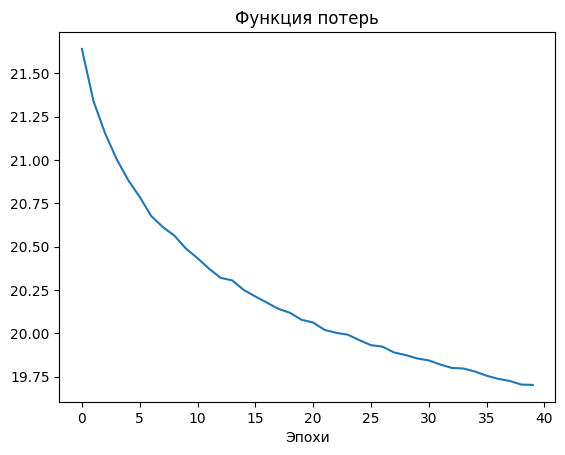

In [ ]:
plt.plot(torch.tensor(train_loss_history).cpu().detach().numpy())
plt.title("Функция потерь")
plt.xlabel("Эпохи")

In [ ]:
model_long.eval()
clf = LogisticRegression(random_state=0)
for (x0, x1), _1, _2 in dataloader:
  clf.fit(model_long(x0.to(device)).cpu().detach().numpy(), _1)
  break

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
cifar10_test = torchvision.datasets.CIFAR10("datasets/cifar10", train=False, download=True)
testset = LightlyDataset.from_torch_dataset(cifar10_test)
# or create a dataset from a folder containing images or videos:
# dataset = LightlyDataset("path/to/folder")

collate_fn = VICRegCollateFunction(input_size=32)

test = torch.utils.data.DataLoader(
    testset,
    batch_size=1024,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=2,
)
accur_long = []
for (x0, x1), _1, _2 in test:
  accur_long.append(accuracy_score(_1, clf.predict(model_long(x0.to(device)).cpu().detach().numpy())))

Files already downloaded and verified


посмотрим на распределение точности по тестовым бакетам, когда размер батча равен 1024

(array([1., 0., 1., 0., 0., 0., 1., 0., 0., 3., 0., 0., 1., 0., 0., 0., 1.,
        0., 0., 1.]),
 array([0.3671875 , 0.37075195, 0.37431641, 0.37788086, 0.38144531,
        0.38500977, 0.38857422, 0.39213867, 0.39570312, 0.39926758,
        0.40283203, 0.40639648, 0.40996094, 0.41352539, 0.41708984,
        0.4206543 , 0.42421875, 0.4277832 , 0.43134766, 0.43491211,
        0.43847656]),
 <BarContainer object of 20 artists>)

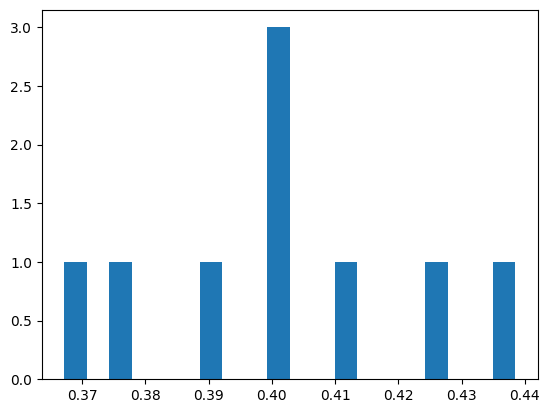

In [ ]:
plt.hist(accur_long, bins = 20)

Модифицируем функцию потерь

In [ ]:
import torch.distributed as dist
import torch.nn.functional as F

from lightly.utils.dist import gather


class VICRegLoss_modified(torch.nn.Module):

    def __init__(
        self,
        lambda_param: float = 25.0,
        mu_param: float = 25.0,
        rho: float = 20.0,
        beta: float = 0.9,
        gather_distributed: bool = False,
        eps=0.0001,
    ):
        """Lambda, mu and nu params configuration with default value like in [0]
        Args:
            lambda_param:
                Coefficient for the invariance term of the loss
                Defaults to 25.0 [0].
            mu_param:
                Coefficient for the variance term of the loss
                Defaults to 25.0 [0].
            nu_param:
                Coefficient for the covariance term of the loss
                Defaults to 1.0 [0].
            gather_distributed:
                If True then the cross-correlation matrices from all gpus are
                gathered and summed before the loss calculation.
            eps:
                Numerical epsilon
                Defaults to 0.0001 [1].
        """
        super(VICRegLoss_modified, self).__init__()
        self.lambda_param = lambda_param
        self.mu_param = mu_param
        self.beta = beta
        self.gather_distributed = gather_distributed
        self.rho = rho
        self.C = None

        self.eps = eps

    def forward(self, z_a: torch.Tensor, z_b: torch.Tensor, update_covariance_matrix: bool = True) -> torch.Tensor:
        assert (
            z_a.shape[0] > 1 and z_b.shape[0] > 1
        ), f"z_a and z_b must have batch size > 1 but found {z_a.shape[0]} and  {z_b.shape[0]}"
        assert (
            z_a.shape == z_b.shape
        ), f"z_a and z_b must have same shape but found {z_a.shape} and {z_b.shape}."

        # invariance term of the loss
        repr_loss = F.mse_loss(z_a, z_b)

        # gather all batches
        if self.gather_distributed and dist.is_initialized():
            world_size = dist.get_world_size()
            if world_size > 1:
                z_a = torch.cat(gather(z_a), dim=0)
                z_b = torch.cat(gather(z_b), dim=0)

        ## tico part

        z_a_tic = torch.nn.functional.normalize(z_a, dim=1)
        z_b_tic = torch.nn.functional.normalize(z_b, dim=1)

        # compute auxiliary matrix B
        B = torch.mm(z_a_tic.T, z_a_tic) / z_a_tic.shape[0]

        # init covariance matrix
        if self.C is None:
            self.C = B.new_zeros(B.shape).detach()

        # compute loss
        C = self.beta * self.C + (1 - self.beta) * B
        # update covariance matrix
        if update_covariance_matrix:
            self.C = C.detach()


        ## end tico part        

        # normalize repr. along the batch dimension
        z_a = z_a - z_a.mean(0)  # NxD
        z_b = z_b - z_b.mean(0)  # NxD

        N = z_a.size(0)
        D = z_a.size(1)

        # variance term of the loss
        std_x = torch.sqrt(z_a.var(dim=0) + self.eps)
        std_y = torch.sqrt(z_b.var(dim=0) + self.eps)
        std_loss = 0.5 * (torch.mean(F.relu(1 - std_x)) + torch.mean(F.relu(1 - std_y)))

        # covariance term of the loss
        cov_x = (z_a.T @ z_a) / (N - 1)
        cov_y = (z_b.T @ z_b) / (N - 1)

        # compute off-diagonal elements
        n, _ = cov_x.shape
        off_diag_cov_x = cov_x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()
        off_diag_cov_y = cov_y.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()

        cov_loss = off_diag_cov_x.pow_(2).sum().div(D) + off_diag_cov_y.pow_(
            2
        ).sum().div(D)

        # loss
        loss = (
            self.lambda_param * repr_loss
            + self.mu_param * std_loss
            + self.rho * (torch.mm(z_a, C) * z_a_tic).sum(dim=1).mean()
        )

        return loss

In [ ]:
resnet = torch.hub.load('facebookresearch/vicreg:main', 'resnet50')
backbone = nn.Sequential(*list(resnet.children())[:-1])
model_long2 = VICReg(backbone)

device = "cuda" if torch.cuda.is_available() else "cpu"
model_long2.to(device)

cifar10 = torchvision.datasets.CIFAR10("datasets/cifar10", train=True, download=True)
dataset = LightlyDataset.from_torch_dataset(cifar10)
# or create a dataset from a folder containing images or videos:
# dataset = LightlyDataset("path/to/folder")

collate_fn = VICRegCollateFunction(input_size=32)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=256,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=2,
)

criterion = VICRegLoss_modified()
optimizer = torch.optim.SGD(model_long2.parameters(), lr=0.06)

train_loss_history = []
print("Starting Training")
model_long2.train()
for epoch in tqdm(range(20)):
    total_loss = 0
    for (x0, x1), _, _ in dataloader:
        x0 = x0.to(device)
        x1 = x1.to(device)
        z0 = model_long2(x0)
        z1 = model_long2(x1)
        loss = criterion(z0, z1)
        total_loss += loss.detach()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    avg_loss = total_loss / len(dataloader)
    train_loss_history.append(avg_loss)
    print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")

Using cache found in /root/.cache/torch/hub/facebookresearch_vicreg_main


Files already downloaded and verified
Starting Training


  0%|          | 0/20 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe1e7b003a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe1e7b003a0>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe1e7b003a0>  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__

    Traceback (most recent call last):
self._shutdown_wo

epoch: 00, loss: 9.87329


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe1e7b003a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe1e7b003a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

epoch: 01, loss: -24.50427


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe1e7b003a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe1e7b003a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

epoch: 02, loss: -27.81977


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe1e7b003a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: 
can only test a child processException ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe1e7b003a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

epoch: 03, loss: -29.43597


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe1e7b003a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fe1e7b003a0>  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    
Traceback (most recent call last):
if w.is_alive():  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__

      File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
self._shutdown_workers()    
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    
AssertionErrorif w.is_alive():: can only test a child process

  File "/usr/lib/pytho

epoch: 04, loss: -29.62887


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe1e7b003a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe1e7b003a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

epoch: 05, loss: -30.52341


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe1e7b003a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe1e7b003a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

epoch: 06, loss: -31.51192


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe1e7b003a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe1e7b003a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

epoch: 07, loss: -32.83757


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe1e7b003a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe1e7b003a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

epoch: 08, loss: -34.10425


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe1e7b003a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe1e7b003a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

epoch: 09, loss: -35.01632


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe1e7b003a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe1e7b003a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

epoch: 10, loss: -35.45972


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe1e7b003a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe1e7b003a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

epoch: 11, loss: -37.52382


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe1e7b003a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe1e7b003a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

epoch: 12, loss: -36.52407


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe1e7b003a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe1e7b003a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

epoch: 13, loss: -39.60130


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe1e7b003a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe1e7b003a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

epoch: 14, loss: -38.86928


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe1e7b003a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe1e7b003a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

epoch: 15, loss: -39.86256


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe1e7b003a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe1e7b003a0>
Traceback (most recent call last):
      File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
assert self._parent_pid == os.getpid(), 'can only test a child process'    self._shutdown_workers()

AssertionError:   File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
can only test a child process
    if w.is_alive():
  File "/usr/lib/pytho

epoch: 16, loss: -41.33659


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe1e7b003a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe1e7b003a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

epoch: 17, loss: -40.41691


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe1e7b003a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe1e7b003a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

epoch: 18, loss: -41.10777


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe1e7b003a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe1e7b003a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

epoch: 19, loss: -42.54026


In [ ]:
cifar10_test = torchvision.datasets.CIFAR10("datasets/cifar10", train=False, download=True)
size = len(cifar10_test)
dataset_indices = list(range(size))
val_index = int(np.floor(0.8 * size))
train_idx, val_idx = dataset_indices[:val_index], dataset_indices[val_index:]
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

train_dataloader = torch.utils.data.DataLoader(
    cifar10_test,
    batch_size=1024,
    collate_fn=collate_fn,
    shuffle=False,
    drop_last=True,
    num_workers=2,
    sampler=train_sampler
)
valid_dataloader = torch.utils.data.DataLoader(
    cifar10_test,
    batch_size=1024,
    collate_fn=collate_fn,
    shuffle=False,
    drop_last=True,
    num_workers=2,
    sampler=val_sampler
)

Files already downloaded and verified


In [ ]:
model_long2.eval()
clf = LogisticRegression(random_state=0)
for (x0, x1), _1, _2 in train_dataloader:
  clf.fit(model_long2(x0.to(device)).cpu().detach().numpy(), _1)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

In [ ]:
accur_long = []
for (x0, x1), _1, _2 in valid_dataloader:
  accur_long.append(accuracy_score(_1, clf.predict(model_long2(x0.to(device)).cpu().detach().numpy())))

In [ ]:
accur_long

[0.3779296875]

In [ ]:
class VICReg(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        self.projection_head = BarlowTwinsProjectionHead(2048, 2048, 2048)

    def forward(self, x):
        x = self.backbone(x).flatten(start_dim=1)
        if self.training:
          out = self.projection_head(x)
        else:
          out = x
        return out


resnet = torch.hub.load('facebookresearch/vicreg:main', 'resnet50')
backbone = nn.Sequential(*list(resnet.children())[:-1])
model_long = VICReg(backbone)

device = "cuda" if torch.cuda.is_available() else "cpu"
model_long.to(device)

cifar10 = torchvision.datasets.CIFAR10("datasets/cifar10", train=True, download=True)
dataset = LightlyDataset.from_torch_dataset(cifar10)
# or create a dataset from a folder containing images or videos:
# dataset = LightlyDataset("path/to/folder")

collate_fn = VICRegCollateFunction(input_size=32)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=256,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=2,
)

criterion = VICRegLoss()
optimizer = torch.optim.SGD(model_long.parameters(), lr=0.06)

train_loss_history = []
print("Starting Training")
model_long.train()
for epoch in tqdm(range(20)):
    total_loss = 0
    for (x0, x1), _, _ in dataloader:
        x0 = x0.to(device)
        x1 = x1.to(device)
        z0 = model_long(x0)
        z1 = model_long(x1)
        loss = criterion(z0, z1)
        total_loss += loss.detach()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    avg_loss = total_loss / len(dataloader)
    train_loss_history.append(avg_loss)
    print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")

Downloading: "https://github.com/facebookresearch/vicreg/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/vicreg/resnet50.pth" to /root/.cache/torch/hub/checkpoints/resnet50.pth
100%|██████████| 90.0M/90.0M [00:04<00:00, 19.5MB/s]


100%|██████████| 170498071/170498071 [00:13<00:00, 12669731.41it/s]


Extracting datasets/cifar10/cifar-10-python.tar.gz to datasets/cifar10
Starting Training


  5%|▌         | 1/20 [01:59<37:45, 119.24s/it]

epoch: 00, loss: 21.64254


 10%|█         | 2/20 [03:50<34:20, 114.49s/it]

epoch: 01, loss: 21.32578


 15%|█▌        | 3/20 [05:37<31:26, 110.99s/it]

epoch: 02, loss: 21.13649


 20%|██        | 4/20 [07:19<28:43, 107.70s/it]

epoch: 03, loss: 21.00072


 25%|██▌       | 5/20 [09:05<26:42, 106.85s/it]

epoch: 04, loss: 20.85894


 30%|███       | 6/20 [10:48<24:38, 105.62s/it]

epoch: 05, loss: 20.77229


 35%|███▌      | 7/20 [12:33<22:51, 105.47s/it]

epoch: 06, loss: 20.68673


 40%|████      | 8/20 [14:17<20:59, 104.94s/it]

epoch: 07, loss: 20.60237


 45%|████▌     | 9/20 [16:04<19:22, 105.69s/it]

epoch: 08, loss: 20.54592


 50%|█████     | 10/20 [17:48<17:29, 104.99s/it]

epoch: 09, loss: 20.48710


 55%|█████▌    | 11/20 [19:33<15:45, 105.11s/it]

epoch: 10, loss: 20.42212


 60%|██████    | 12/20 [21:18<13:59, 104.95s/it]

epoch: 11, loss: 20.38983


 65%|██████▌   | 13/20 [23:00<12:08, 104.07s/it]

epoch: 12, loss: 20.33327


 70%|███████   | 14/20 [24:45<10:25, 104.31s/it]

epoch: 13, loss: 20.28947


 75%|███████▌  | 15/20 [26:27<08:38, 103.77s/it]

epoch: 14, loss: 20.24804


 80%|████████  | 16/20 [28:10<06:53, 103.41s/it]

epoch: 15, loss: 20.21679


 85%|████████▌ | 17/20 [29:54<05:11, 103.76s/it]

epoch: 16, loss: 20.19238


 90%|█████████ | 18/20 [31:38<03:27, 103.79s/it]

epoch: 17, loss: 20.15501


 95%|█████████▌| 19/20 [33:24<01:44, 104.31s/it]

epoch: 18, loss: 20.12943


100%|██████████| 20/20 [35:06<00:00, 105.33s/it]

epoch: 19, loss: 20.09366


In [ ]:
cifar10_test = torchvision.datasets.CIFAR10("datasets/cifar10", train=False, download=True)
testset = LightlyDataset.from_torch_dataset(cifar10_test)
size = len(testset)
dataset_indices = list(range(size))
val_index = int(np.floor(0.8 * size))
train_idx, val_idx = dataset_indices[:val_index], dataset_indices[val_index:]
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

train_dataloader = torch.utils.data.DataLoader(
    testset,
    batch_size=1024,
    collate_fn=collate_fn,
    shuffle=False,
    drop_last=True,
    num_workers=2,
    sampler=train_sampler
)
valid_dataloader = torch.utils.data.DataLoader(
    testset,
    batch_size=1024,
    collate_fn=collate_fn,
    shuffle=False,
    drop_last=True,
    num_workers=2,
    sampler=val_sampler
)

Files already downloaded and verified


In [ ]:
model_long.eval()
clf = LogisticRegression(random_state=0)
for (x0, x1), _1, _2 in train_dataloader:
  clf.fit(model_long(x0.to(device)).cpu().detach().numpy(), _1)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

In [ ]:
accur_long = []
for (x0, x1), _1, _2 in valid_dataloader:
  accur_long.append(accuracy_score(_1, clf.predict(model_long(x0.to(device)).cpu().detach().numpy())))

In [ ]:
accur_long

[0.421875]

In [ ]:
class VICReg(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        self.projection_head = BarlowTwinsProjectionHead(2048, 2048, 2048)

    def forward(self, x):
        x = self.backbone(x).flatten(start_dim=1)
        if self.training:
          out = self.projection_head(x)
        else:
          out = x
        return out


resnet = torch.hub.load('facebookresearch/vicreg:main', 'resnet50')
backbone = nn.Sequential(*list(resnet.children())[:-1])
model_l = VICReg(backbone)

device = "cuda" if torch.cuda.is_available() else "cpu"
model_l.to(device)

cifar10 = torchvision.datasets.CIFAR10("datasets/cifar10", train=True, download=True)
dataset = LightlyDataset.from_torch_dataset(cifar10)
# or create a dataset from a folder containing images or videos:
# dataset = LightlyDataset("path/to/folder")

collate_fn = VICRegCollateFunction(input_size=32)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=256,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=2,
)

criterion = TiCoLoss()
optimizer = torch.optim.SGD(model_l.parameters(), lr=0.06)

train_loss_history = []
print("Starting Training")
model_l.train()
for epoch in tqdm(range(20)):
    total_loss = 0
    for (x0, x1), _, _ in dataloader:
        x0 = x0.to(device)
        x1 = x1.to(device)
        z0 = model_l(x0)
        z1 = model_l(x1)
        loss = criterion(z0, z1)
        total_loss += loss.detach()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    avg_loss = total_loss / len(dataloader)
    train_loss_history.append(avg_loss)
    print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")

Downloading: "https://github.com/facebookresearch/vicreg/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/vicreg/resnet50.pth" to /root/.cache/torch/hub/checkpoints/resnet50.pth
100%|██████████| 90.0M/90.0M [00:04<00:00, 19.4MB/s]


Files already downloaded and verified
Starting Training


  5%|▌         | 1/20 [01:51<35:24, 111.80s/it]

epoch: 00, loss: 0.96800


 10%|█         | 2/20 [03:37<32:26, 108.16s/it]

epoch: 01, loss: 0.95287


 15%|█▌        | 3/20 [05:24<30:31, 107.75s/it]

epoch: 02, loss: 0.94777


 20%|██        | 4/20 [07:08<28:21, 106.34s/it]

epoch: 03, loss: 0.94338


 25%|██▌       | 5/20 [08:55<26:34, 106.28s/it]

epoch: 04, loss: 0.93953


 30%|███       | 6/20 [10:41<24:47, 106.28s/it]

epoch: 05, loss: 0.93437


 35%|███▌      | 7/20 [12:29<23:10, 106.93s/it]

epoch: 06, loss: 0.93041


 40%|████      | 8/20 [14:13<21:13, 106.12s/it]

epoch: 07, loss: 0.92703


 45%|████▌     | 9/20 [16:01<19:30, 106.44s/it]

epoch: 08, loss: 0.92326


 50%|█████     | 10/20 [17:48<17:47, 106.79s/it]

epoch: 09, loss: 0.91973


 55%|█████▌    | 11/20 [19:33<15:56, 106.31s/it]

epoch: 10, loss: 0.91527


 60%|██████    | 12/20 [21:18<14:06, 105.86s/it]

epoch: 11, loss: 0.91051


 65%|██████▌   | 13/20 [23:07<12:26, 106.61s/it]

epoch: 12, loss: 0.90870


 70%|███████   | 14/20 [24:53<10:38, 106.48s/it]

epoch: 13, loss: 0.90396


 75%|███████▌  | 15/20 [26:39<08:51, 106.34s/it]

epoch: 14, loss: 0.90189


 80%|████████  | 16/20 [28:25<07:04, 106.18s/it]

epoch: 15, loss: 0.89823


 85%|████████▌ | 17/20 [30:11<05:18, 106.28s/it]

epoch: 16, loss: 0.89551


 90%|█████████ | 18/20 [31:55<03:31, 105.52s/it]

epoch: 17, loss: 0.89196


 95%|█████████▌| 19/20 [33:43<01:46, 106.29s/it]

epoch: 18, loss: 0.88908


100%|██████████| 20/20 [35:29<00:00, 106.45s/it]

epoch: 19, loss: 0.88607


In [ ]:
cifar10_test = torchvision.datasets.CIFAR10("datasets/cifar10", train=False, download=True)
testset = LightlyDataset.from_torch_dataset(cifar10_test)
size = len(testset)
dataset_indices = list(range(size))
val_index = int(np.floor(0.8 * size))
train_idx, val_idx = dataset_indices[:val_index], dataset_indices[val_index:]
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

train_dataloader = torch.utils.data.DataLoader(
    testset,
    batch_size=1024,
    collate_fn=collate_fn,
    shuffle=False,
    drop_last=True,
    num_workers=2,
    sampler=train_sampler
)
valid_dataloader = torch.utils.data.DataLoader(
    testset,
    batch_size=1024,
    collate_fn=collate_fn,
    shuffle=False,
    drop_last=True,
    num_workers=2,
    sampler=val_sampler
)

Files already downloaded and verified


In [ ]:
model_l.eval()
clf = LogisticRegression(random_state=0)
for (x0, x1), _1, _2 in train_dataloader:
  clf.fit(model_l(x0.to(device)).cpu().detach().numpy(), _1)

In [ ]:
accur_l = []
for (x0, x1), _1, _2 in valid_dataloader:
  accur_l.append(accuracy_score(_1, clf.predict(model_l(x0.to(device)).cpu().detach().numpy())))

In [ ]:
accur_l

[0.3046875]